Video file: Dataset/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi
Total frames: 123
FPS: 25.0
Resolution: 320 x 240


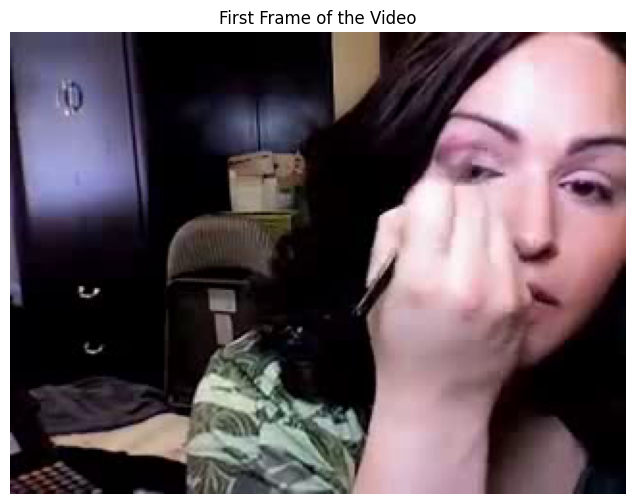

In [56]:
import cv2
import matplotlib.pyplot as plt

# Specify a sample video file path (adjust the path if needed)
sample_video = 'Dataset/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi'

# Open the video file
cap = cv2.VideoCapture(sample_video)
if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    # Retrieve video properties
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print("Video file:", sample_video)
    print("Total frames:", frame_count)
    print("FPS:", fps)
    print("Resolution: {} x {}".format(width, height))
    
    # Read the first frame
    ret, frame = cap.read()
    if ret:
        # Convert color from BGR to RGB for display purposes
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8,6))
        plt.imshow(frame_rgb)
        plt.title("First Frame of the Video")
        plt.axis('off')
        plt.show()
    else:
        print("Error: Could not read the first frame.")
    
    cap.release()


In [57]:
def load_video(video_path):
    """
    Loads a video file and returns a video tensor.
    The video tensor shape will be (num_frames, height, width, channels).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    
    # Convert frames list to a tensor (numpy array)
    import numpy as np
    video_tensor = np.array(frames)  # shape: (num_frames, height, width, channels)
    return video_tensor

# Test the function by loading a video and printing its shape
video_tensor = load_video(sample_video)
print("Loaded video shape:", video_tensor.shape)


Loaded video shape: (123, 240, 320, 3)


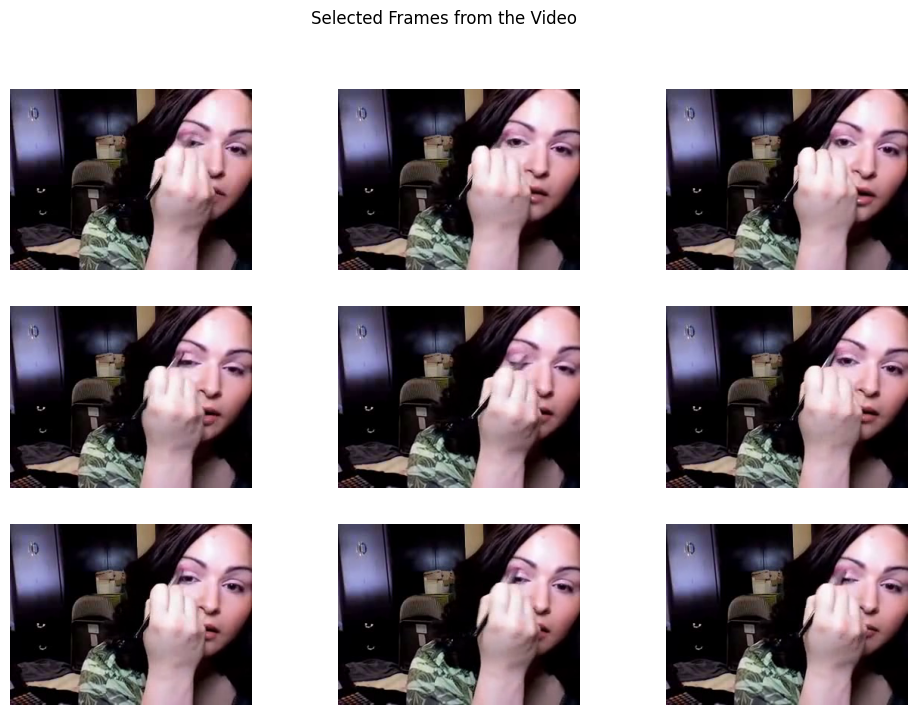

In [58]:
import matplotlib.pyplot as plt

def display_frames(video_tensor, num_frames=9):
    """
    Displays a grid of frames from the video tensor.
    """
    total_frames = video_tensor.shape[0]
    interval = max(total_frames // num_frames, 1)
    
    selected_frames = video_tensor[::interval][:num_frames]
    
    # Calculate grid size
    grid_size = int(num_frames**0.5)
    if grid_size * grid_size < num_frames:
        grid_size += 1
    
    plt.figure(figsize=(12, 8))
    for i, frame in enumerate(selected_frames):
        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(frame)
        plt.axis('off')
    plt.suptitle("Selected Frames from the Video")
    plt.show()

# Display frames from the loaded video
display_frames(video_tensor, num_frames=9)


In [59]:
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

In [60]:
# Configuration
FRAMES_PER_VIDEO = 30  # Number of frames per video clip
IMG_HEIGHT, IMG_WIDTH = 64, 64  #Frame dimensions
BATCH_SIZE = 8
EPOCHS = 3
NUM_CLASSES = len(os.listdir("Dataset/train"))  # Automatically get class count

In [61]:
def get_video_paths_and_labels(base_dir):
    classes = sorted(os.listdir(base_dir))
    video_paths, labels = [], []
    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        for video_file in os.listdir(class_dir):
            video_paths.append(os.path.join(class_dir, video_file))
            labels.append(class_name)
    return video_paths, labels

train_paths, train_labels = get_video_paths_and_labels("Dataset/train")
val_paths, val_labels = get_video_paths_and_labels("Dataset/val")
test_paths, test_labels = get_video_paths_and_labels("Dataset/test")

In [62]:
# Add this check before label encoding
train_classes = set(os.listdir("Dataset/train"))
val_classes = set(os.listdir("Dataset/val"))
test_classes = set(os.listdir("Dataset/test"))

assert train_classes == val_classes == test_classes, "Class mismatch between splits"

In [63]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels = le.transform(val_labels)
test_labels = le.transform(test_labels)

In [64]:
# Convert to int32 explicitly after encoding
train_labels = le.fit_transform(train_labels).astype('int32')
val_labels = le.transform(val_labels).astype('int32')
test_labels = le.transform(test_labels).astype('int32')

In [65]:
def process_video(path, label):
    cap = cv2.VideoCapture(path.numpy().decode('utf-8'))
    frames = []
    for _ in range(FRAMES_PER_VIDEO):
        ret, frame = cap.read()
        frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))/255.0 if ret else np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
        frames.append(frame)
    cap.release()
    return np.array(frames, dtype=np.float32), np.int32(label)  # Explicit cast

def tf_process_video(path, label):
    video, label = tf.py_function(
        process_video,
        [path, label],
        (tf.float32, tf.int32)  # Ensure output dtype matches
    )
    video.set_shape((FRAMES_PER_VIDEO, IMG_HEIGHT, IMG_WIDTH, 3))
    label.set_shape(())
    return video, label

In [66]:
# Get paths and labels
train_paths, train_labels = get_video_paths_and_labels("Dataset/train")
val_paths, val_labels = get_video_paths_and_labels("Dataset/val")

# Encode with int32 conversion
le = LabelEncoder()
train_labels = le.fit_transform(train_labels).astype('int32')
val_labels = le.transform(val_labels).astype('int32')

In [67]:
print(f"Label dtype: {train_labels.dtype}")  # Should show int32

Label dtype: int32


In [68]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(tf_process_video).batch(BATCH_SIZE).prefetch(2)

In [69]:
def create_dataset(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(tf_process_video, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset(train_paths, train_labels)
val_ds = create_dataset(val_paths, val_labels)
test_ds = create_dataset(test_paths, test_labels)

In [70]:
model = tf.keras.Sequential([
    layers.Input(shape=(FRAMES_PER_VIDEO, IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # 3D Convolutional Blocks
    layers.Conv3D(16, (3, 3, 3), activation='relu'),
    layers.MaxPool3D((2, 2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv3D(32, (3, 3, 3), activation='relu'),
    layers.MaxPool3D((2, 2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv3D(64, (3, 3, 3), activation='relu'),
    layers.MaxPool3D((2, 2, 2)),
    layers.BatchNormalization(),
    
    # Classifier
    layers.GlobalAveragePooling3D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [71]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/3
1257/1257 [==============================] - 112s 89ms/step - loss: 4.8584 - accuracy: 0.0062 - val_loss: 4.6465 - val_accuracy: 0.0149
Epoch 2/3
1257/1257 [==============================] - 95s 75ms/step - loss: 4.4585 - accuracy: 0.0143 - val_loss: 4.6282 - val_accuracy: 0.0197
Epoch 3/3
1257/1257 [==============================] - 94s 75ms/step - loss: 4.2131 - accuracy: 0.0108 - val_loss: 4.6185 - val_accuracy: 0.0203


In [72]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

216/216 [==============================] - 16s 74ms/step - loss: 4.6200 - accuracy: 0.0203
Test Accuracy: 2.03%
